In [91]:
from IPython.display import Image

from pymol import cmd,stored
from IPython.display import display,Image
from tqdm import tqdm_notebook

import os, sys, time,imageio
from random import sample

In [135]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import SimilarityMaps, IPythonConsole
from rdkit.Chem import Draw

import numpy as np
import pandas as pd
import rdkit.Chem.Lipinski as Lipinksy
import pubchempy as pcp

##### Для начала загрузим структуру молекулы ибупрофена, конвертируем изображение из SMILES

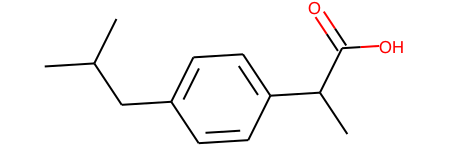

In [60]:
ibu=Chem.MolFromSmiles('CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')
AllChem.Compute2DCoords(ibu)
display(ibu)

##### Сделаем функцию, которая будет проверять молекулу на предмет удовлетворения правилам Лепински 

In [61]:
def Lipinsky_checking(comp):
    a1 = Lipinksy.NumHDonors(comp) <= 5 
    a2 = Lipinksy.NumHAcceptors(comp) <= 10
    a3 = Lipinksy.rdMolDescriptors.CalcExactMolWt(comp) < 500
    a4 = Lipinksy.rdMolDescriptors.CalcCrippenDescriptors(ibu)[0] <= 5
    return  a1&a2&a3&a4

In [62]:
Lipinsky_checking(ibu)  #работает 

True

##### Со скачиванием онлайн возникли проблемы, возьмем скаченный вручную список азидов

In [5]:
compounds_all = []
per_page = 10**5
for smiles in ["N=N=N", "NN#N",]:
    for i in tqdm(range(1000)):
        try:
            a = pcp.get_properties(
              properties="CanonicalSMILES", 
              identifier=smiles,
              namespace="smiles", 
              searchtype="substructure",
              RingsNotEmbedded=True,
              listkey_count=per_page, 
              listkey_start=i*per_page
            )
        except:
            print("Page {} returns 500, which is"
                 "our signal to stop.".format(i+1))
            break
        print("Retrieved page {} of {} search".format(i+1, smiles))
        compounds_all.extend(a)

  0%|          | 0/1000 [00:00<?, ?it/s]

Page 1 returns 500, which isour signal to stop.
Page 1 returns 500, which isour signal to stop.


In [12]:
azids = pd.read_csv("/Users/ann/Downloads/azids.csv")

In [121]:
print(azids.shape)
azids.head()

(176485, 3)


,Unnamed: 0,CID,CanonicalSMILES
0,0,145926031,C1=CC(=CC=C1C2=NOC(=C2)C3=NC(=CS3)C4=CC=NC=C4)...
1,1,145927246,C(CCl)N=[N+]=N
2,2,145927073,COC(=O)C1CC(CN1C(=O)OCC2=CC=CC=C2)N=[N+]=N
3,3,145926982,CN1CCN(CC1)C2=C(C=C(C=C2)N=[N+]=N)[N+](=O)[O-]
4,4,145926828,CSC1=NC=C(C(=N1)CN=[N+]=N)Br


##### Отфильтруем список, чтобы в нем остались только рабочие формулы

In [122]:
workig_azids =[i for i in azids.CanonicalSMILES if len(i) < 30 and len(i) > 1 and '.' not in i]

In [123]:
len(workig_azids), workig_azids[0]

(15441, 'C(CCl)N=[N+]=N')

##### Теперь преобразуем ибупрофен, чтобы его структуру можно было использовать для кликхимии (введем азидную группу)

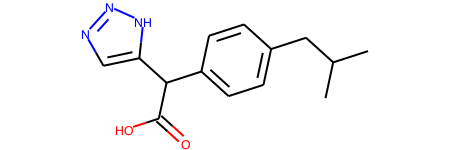

In [124]:
for_azid = Chem.MolFromSmiles('N1N=NC=C1C(C(O)=O)C(C=C1)=CC=C1CC(C)C')
AllChem.Compute2DCoords(for_azid)
display(for_azid)

In [127]:
for_azid_smiles = 'N1N=NC=C1C(C(O)=O)C(C=C1)=CC=C1CC(C)C'
products = []
for azid in workig_azids:
    if "N=[N+]=[N-]" in azid:
        azid_ibu = azid.replace("N=[N+]=[N-]", for_azid_smiles)
        try: 
            new_mol = Chem.MolFromSmiles(azid_ibu)
            if Lipinsky_checking(new_mol):
                products.append(new_mol)
        except Exception:
            pass
        
len(products)

RDKit ERROR: [18:34:21] Explicit valence for atom # 1 Cl, 3, is greater than permitted
RDKit ERROR: [18:34:22] Explicit valence for atom # 4 Cl, 3, is greater than permitted
RDKit ERROR: [18:34:25] Explicit valence for atom # 25 Cl, 3, is greater than permitted


14572

#### Посмотрим, что у нас в списке

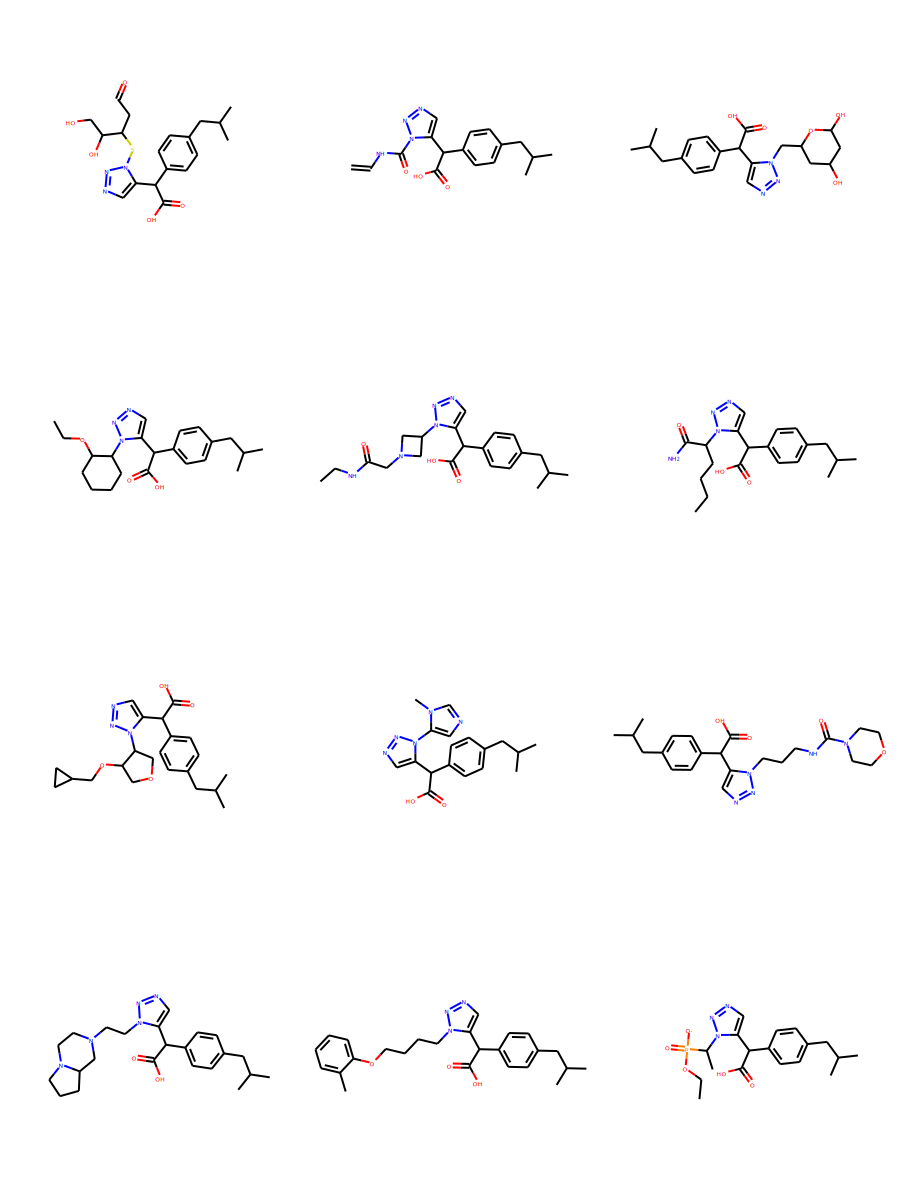

In [134]:
for_pic = [products[i] for i in  np.random.randint(0, len(products)-1, size=(1,12)).ravel()]
Chem.Draw.MolsToGridImage(for_pic,useSVG=True, molsPerRow=3, subImgSize=(300, 300))

### Посмотрим, насколько похожа одна из новых молекул на ибупрофен

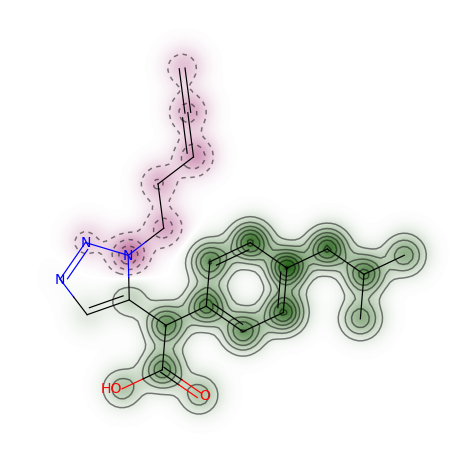

In [136]:
similarity_map = SimilarityMaps.GetMorganFingerprint(products[4], fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(for_azid, products[4], SimilarityMaps.GetMorganFingerprint)

##### Ну чтож, довольная похожа

### Посмтрим, как отобразиться эта молекула в 3d

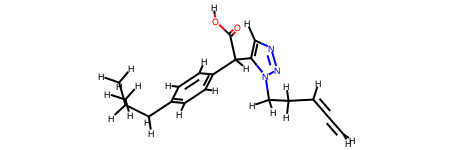

In [142]:
new_pic = Chem.AddHs(products[4])
Chem.AllChem.EmbedMolecule(new_pic)
AllChem.MMFFOptimizeMolecule(new_pic, maxIters=500, nonBondedThresh=200)
display(new_pic)

##### Немного грустно